

En los últimos años, el aumento sostenido de los precios en Cuba ha generado una
brecha cada vez mayor entre los ingresos de la población y el costo de los bienes
básicos. En este contexto, las MIPYMES han adquirido un papel central en la oferta
de productos, pero también han sido señaladas como uno de los factores que inciden
en el encarecimiento del mercado.

El objetivo de este proyecto es analizar el comportamiento de los precios de
productos básicos en MIPYMES y compararlos con el mercado estatal, con el fin de
estimar el costo real de la canasta básica y evaluar su accesibilidad en relación
con el salario mínimo.


## Alcance del análisis

Para el desarrollo de este proyecto se utilizaron datos provenientes de múltiples
fuentes, con el objetivo de combinar información del mercado real con indicadores
oficiales.

- **MIPYMES**: precios de productos ofrecidos por micro, pequeñas y medianas
  empresas, representando una parte significativa del mercado no estatal.
- **El Yerro Menu**: es una plataforma digital que agrupa mercados y negocios, estos pueden operar a través de locales físicos, ventas en línea, o una combinación de ambos.

- **ONEI (Oficina Nacional de Estadística e Información)**: datos oficiales del
  salarios.
- **Ministerio de Economía y Planificación**: información oficial sobre el contexto
  económico nacional.
- **Otros sitios oficiales cubanos**: utilizados como complemento institucional
  para contextualizar los resultados del análisis.

El uso de múltiples fuentes permite contrastar precios del mercado con información
oficial, fortaleciendo la validez del análisis.

In [16]:
# Con estas 2 lineas recargamos automaticamente todos los archivos afiliados al proyecto, sin necesidad de usar el boton de Restart
%load_ext autoreload
%autoreload 2

from modules.open_json import open_json
import folium
 
mypime = list(open_json("../json/mypime.json"))
geojson = open_json("../json/lha.geojson")
canasta_basica = open_json("../json/canasta_basica.json")
revolico = open_json("../json/revolico.json ")
yerro_m = open_json("./modules/scraping/json_yerro_m/yerro_m.json")


provincia_map = folium.Map(location=(23.133865,-82.3585654))

for i in range(len(mypime)):
    if mypime[i]["ubicacion"]["lat"] is not None and mypime[i]["ubicacion"]["long"] is not None:
        
        folium.Marker(
            location=[mypime[i]["ubicacion"]["lat"], mypime[i]["ubicacion"]["long"]],
            tooltip=f"{mypime[i]["nombre"]}",
            icon=folium.Icon(icon="shopping-cart", color="blue")
        ).add_to(provincia_map)

for j in range(len(yerro_m)):
    if yerro_m[j]["ubicacion"]["lat"] is not None and yerro_m[j]["ubicacion"]["long"] is not None:
             
        folium.Marker(
            location=[yerro_m[j]["ubicacion"]["lat"], yerro_m[j]["ubicacion"]["long"]],
            tooltip=f"{yerro_m[j]["nombre"]}",
            popup= f"<h3>Municipio: {yerro_m[j]["municipio"]}✅  Horario: {yerro_m[j]["horario"]} ⏰</h3>",
            icon=folium.Icon(icon="shopping-cart", color="red")
        ).add_to(provincia_map)
        
        
folium.GeoJson(geojson,
               style_function= lambda x: {
                   "fillColor": "#93FF69",
                   "color": "#08CB00"
               }
               ).add_to(provincia_map)
folium
    
provincia_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Composición del mercado

Antes de analizar precios, se examina qué tipo de productos dominan la oferta, con énfasis en la diferencia entre productos nacionales e importados.


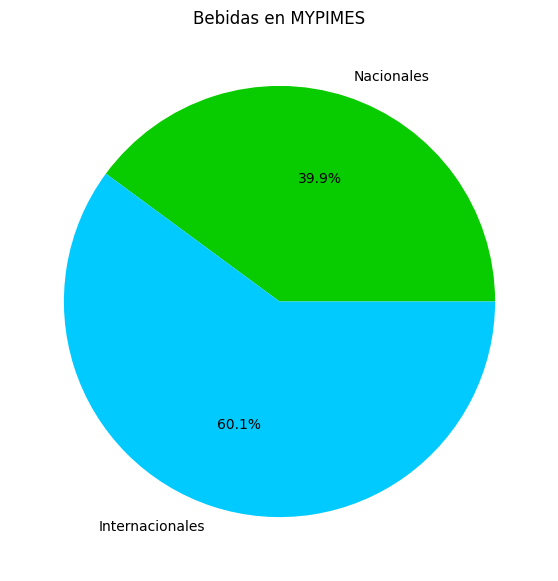

In [17]:
from modules.graphs import bebidas_porciento, yerro_bebida
bebidas_porciento(yerro_bebida(yerro_m))

La mayor presencia de productos importados sugiere una dependencia del mercado externo, lo que puede influir en la estructura de precios observada posteriormente.


## Concentración de marcas

Analizar las marcas más comercializadas permite evaluar el nivel de diversidad y competencia en el mercado.


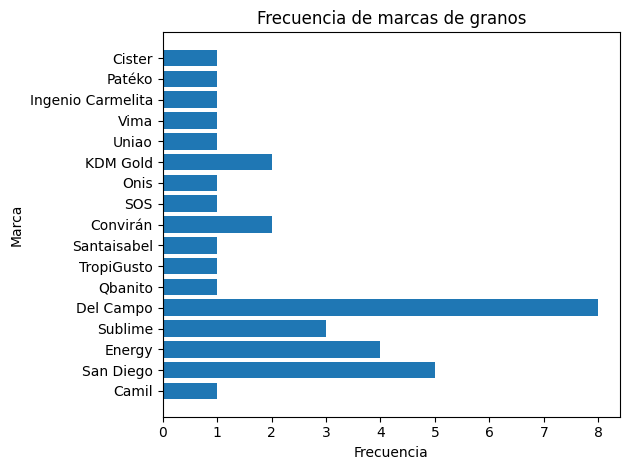

In [18]:
from modules.graphs import productos_mypimes, marcas
import matplotlib.pyplot as plt

a = productos_mypimes(mypime)
marcas(a)


La concentración en un número reducido de marcas indica un mercado poco diversificado, donde la capacidad de elección del consumidor es limitada.


## Precios promedio de los productos

Una vez identificados los productos más relevantes, se analizan sus precios promedio para caracterizar el comportamiento general del mercado.


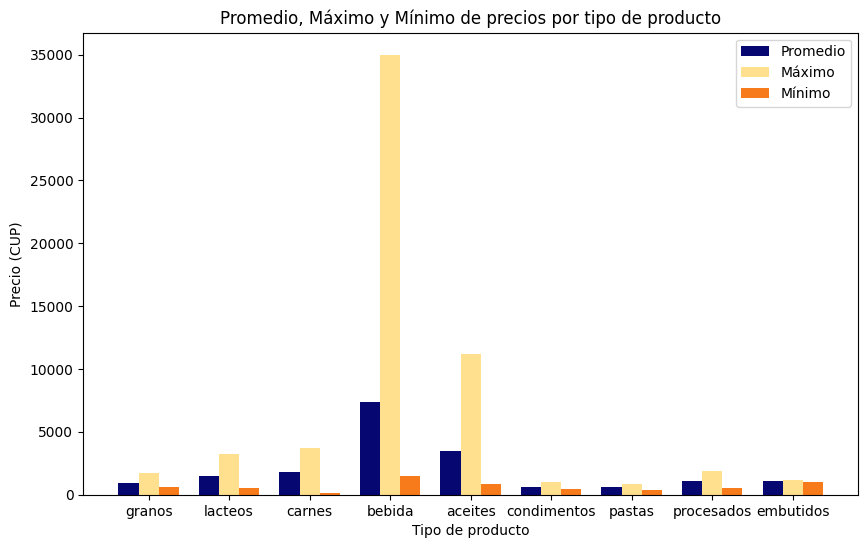

In [19]:
from modules.graphs import pmm, productos_mypimes
def precios():
    
    tipos_precios = {}
    
    for tienda in productos_mypimes(mypime):
        tipo = tienda["tipo"]
        precio = tienda["precio_cup"]


        if tipo not in tipos_precios:
            tipos_precios[tipo] = []
        tipos_precios[tipo].append(precio)
        
    
    tipos = list(tipos_precios.keys())
    promedios = []
    maximos = []
    minimos = []
    
    for tipo in tipos:
        precios = tipos_precios[tipo]
        promedios.append(sum(precios) / len(precios))
        maximos.append(max(precios))
        minimos.append(min(precios))
    
    pmm(tipos, promedios, maximos, minimos)

precios()

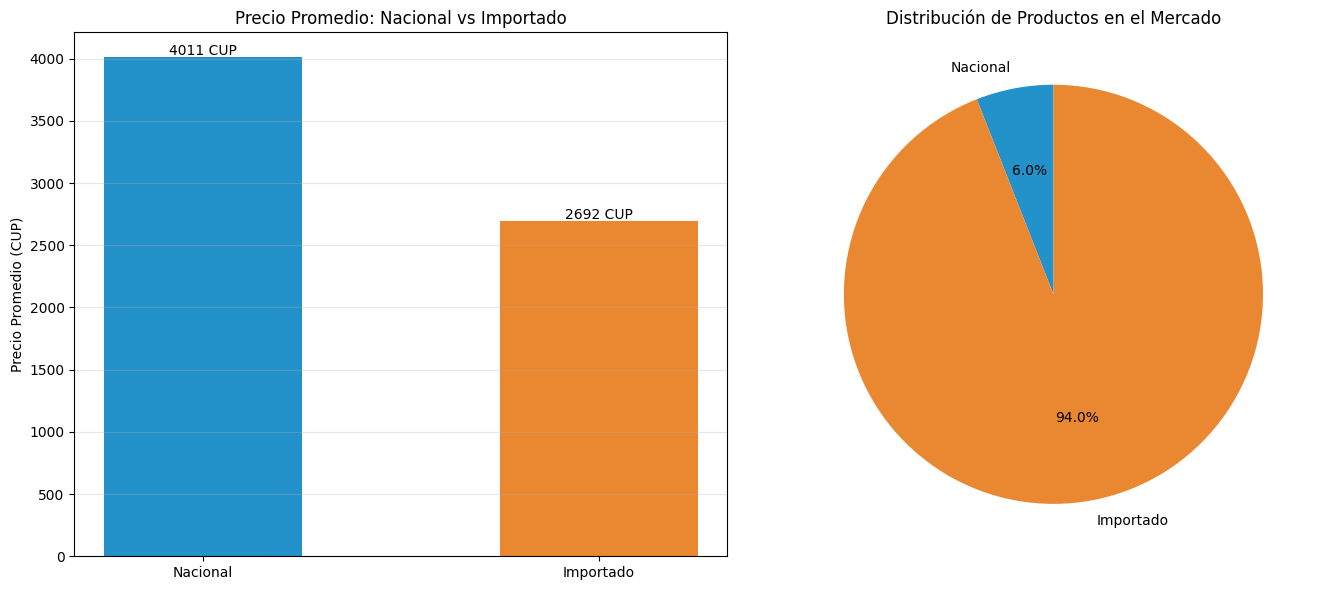

In [20]:
from modules.graphs import promedio, productos_mypimes
def analizar_nacional_vs_importado():
    
    productos = productos_mypimes(mypime)
    
    nacionales = []
    importados = []
    
    for tienda in productos:
            if "nacional" in tienda:
                if tienda["nacional"] == True:
                    nacionales.append(tienda["precio_cup"])
                else:
                    importados.append(tienda["precio_cup"])
    
    promedio_nacional = promedio(nacionales)
    promedio_importado = promedio(importados)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # barras
    categorias = ["Nacional", "Importado"]
    promedios = [promedio_nacional, promedio_importado]
    colores_barras = ["#2492CA", "#ea8832"]
    
    ax1.bar(categorias, promedios, color=colores_barras, width=0.5)
    ax1.set_ylabel("Precio Promedio (CUP)")
    ax1.set_title("Precio Promedio: Nacional vs Importado")
    ax1.grid(axis="y", alpha=0.3)
    
    for i, v in enumerate(promedios):
        ax1.text(i, v + 20, f"{v:.0f} CUP", ha="center")
    
    # pastel
    cantidades = [len(nacionales), len(importados)]
    ax2.pie(cantidades, labels=categorias, autopct="%1.1f%%", colors=colores_barras, startangle=90)
    ax2.set_title("Distribución de Productos en el Mercado")
    
    plt.tight_layout()
    plt.show()

analizar_nacional_vs_importado()

Los precios promedio muestran diferencias significativas entre productos y mercados, evidenciando la ausencia de una referencia homogénea de precios.


## La canasta básica como punto de quiebre

Más allá de productos individuales, se estima el costo de una canasta mínima basada en gramajes de consumo.

Este cálculo permite evaluar si el salario puede sostener una alimentación básica.


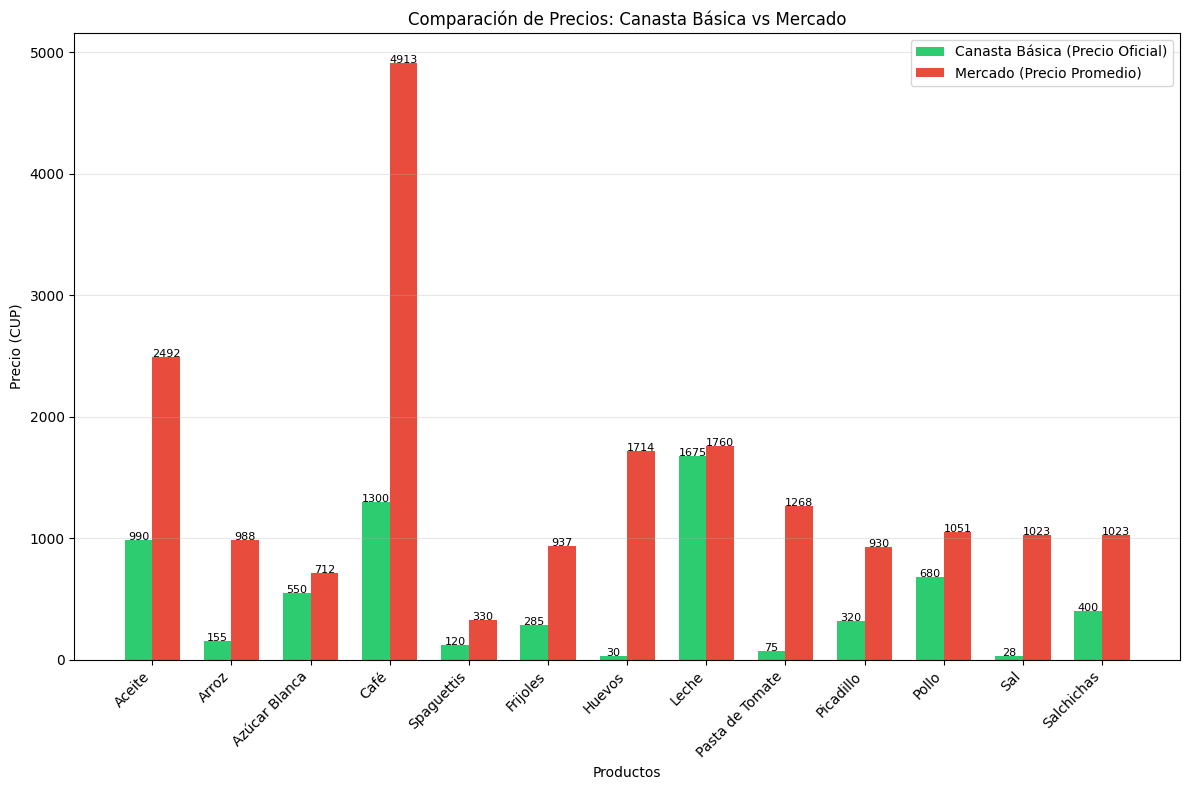


ESTADÍSTICAS DE COMPARACIÓN
Aceite:
  Oficial: 990 CUP
  Mercado: 2492 CUP
  Diferencia: +1502 CUP 

Arroz:
  Oficial: 155 CUP
  Mercado: 988 CUP
  Diferencia: +833 CUP 

Azúcar Blanca:
  Oficial: 550 CUP
  Mercado: 712 CUP
  Diferencia: +162 CUP 

Café:
  Oficial: 1300 CUP
  Mercado: 4913 CUP
  Diferencia: +3613 CUP 

Spaguettis:
  Oficial: 120 CUP
  Mercado: 330 CUP
  Diferencia: +210 CUP 

Frijoles:
  Oficial: 285 CUP
  Mercado: 937 CUP
  Diferencia: +652 CUP 

Huevos:
  Oficial: 30 CUP
  Mercado: 1714 CUP
  Diferencia: +1684 CUP 

Leche:
  Oficial: 1675 CUP
  Mercado: 1760 CUP
  Diferencia: +85 CUP 

Pasta de Tomate:
  Oficial: 75 CUP
  Mercado: 1268 CUP
  Diferencia: +1193 CUP 

Picadillo:
  Oficial: 320 CUP
  Mercado: 930 CUP
  Diferencia: +610 CUP 

Pollo:
  Oficial: 680 CUP
  Mercado: 1051 CUP
  Diferencia: +371 CUP 

Sal:
  Oficial: 28 CUP
  Mercado: 1023 CUP
  Diferencia: +995 CUP 

Salchichas:
  Oficial: 400 CUP
  Mercado: 1023 CUP
  Diferencia: +623 CUP 



In [21]:
from modules.graphs import promedio, union, productos_mypimes, productos_yerro, cbasica
from modules.scraping.eltoque import eltoque_scraper
import matplotlib.pyplot as plt
import numpy as np

# tasas_cambio = eltoque_scraper()
cb_nombre_productos, cb_productos = cbasica(canasta_basica)

salario_minimo = 2100  
salario_medio = 4500   

horas_dia = 8
dias_mes = 22
horas_mes = horas_dia * dias_mes  

total_canasta_basica = 0
for i in cb_productos:
    total_canasta_basica += i

productos_m_y = []
for j in union(productos_mypimes(mypime), productos_yerro(yerro_m)):
    productos_m_y.append(
        {
            "nombre": j.get("nombre"),
            "precio": j.get("precio_cup")
        }
    )
  
cb_in_union = []
for cb in cb_nombre_productos:
    for my in productos_m_y:
        if cb is not None and my["nombre"] is not None:
            if cb in my["nombre"]:
                cb_in_union.append(my)

#---------------------------------

arroz = []
frijoles = []
aceite = []
azucar = []
sal = []
leche = []
leche_condensada = []
salchicha = []
huevos = []
picadillo = []
pollo = []
cafe = []
pechuga_pollo = []
spagutti = []
pasta_tomate = []

for k in cb_in_union:
    nombre_lower = k["nombre"].lower()
    
    if "arroz" in nombre_lower:
        arroz.append(k.get("precio"))
        
    if "frijoles" in nombre_lower:
        frijoles.append(k.get("precio"))

    if "aceite" in nombre_lower:
        aceite.append(k.get("precio"))
        
    if "azucar" in nombre_lower or "azúcar" in nombre_lower:
        azucar.append(k.get("precio"))
        
    if "sal" in nombre_lower:
        sal.append(k.get("precio"))
        
    if "leche" in nombre_lower and "condensada" not in nombre_lower:
        leche.append(k.get("precio"))
        
    if "leche condensada" in nombre_lower:
        leche_condensada.append(k.get("precio"))
        
    if "salchicha" in nombre_lower:
        salchicha.append(k.get("precio"))
        
    if "huevo" in nombre_lower:
        huevos.append(k.get("precio"))
        
    if "picadillo" in nombre_lower:
        picadillo.append(k.get("precio"))
        
    if "pollo" in nombre_lower and "pechuga" not in nombre_lower:
        pollo.append(k.get("precio"))
        
    if "cafe" in nombre_lower or "café" in nombre_lower:
        cafe.append(k.get("precio"))

    if "pechuga de pollo" in nombre_lower or "pechuga pollo" in nombre_lower:
        pechuga_pollo.append(k.get("precio"))
        
    if "spaguetti" in nombre_lower or "spaghetti" in nombre_lower:
        spagutti.append(k.get("precio"))
    
    if "pasta de tomate" in nombre_lower:
        pasta_tomate.append(k.get("precio"))

def calcular_promedio(lista):
    return promedio(lista) if lista else 0

p_aceite = calcular_promedio(aceite)
p_arroz = calcular_promedio(arroz)
p_azucar = calcular_promedio(azucar)
p_cafe = calcular_promedio(cafe)
p_spagutti = calcular_promedio(spagutti)
p_frijoles = calcular_promedio(frijoles)
p_huevos = calcular_promedio(huevos)
p_leche = calcular_promedio(leche)
p_leche_condensada = calcular_promedio(leche_condensada)
p_pasta_tomate = calcular_promedio(pasta_tomate)
p_pechuga_pollo = calcular_promedio(pechuga_pollo)
p_picadillo = calcular_promedio(picadillo)
p_pollo = calcular_promedio(pollo)
p_sal = calcular_promedio(sal)
p_salchicha = calcular_promedio(salchicha)

lista_nombre = cb_nombre_productos 
lista_precio = []

for producto in cb_nombre_productos:
    producto_lower = producto.lower()
    
    if "arroz" in producto_lower:
        lista_precio.append(p_arroz)
    elif "frijoles" in producto_lower:
        lista_precio.append(p_frijoles)
    elif "leche" in producto_lower and "condensada" not in producto_lower:
        lista_precio.append(p_leche)
    elif "leche condensada" in producto_lower:
        lista_precio.append(p_leche_condensada)
    elif "aceite" in producto_lower:
        lista_precio.append(p_aceite)
    elif "sal" in producto_lower:
        lista_precio.append(p_sal)
    elif "salchicha" in producto_lower:
        lista_precio.append(p_salchicha)
    elif "huevo" in producto_lower:
        lista_precio.append(p_huevos)
    elif "picadillo" in producto_lower:
        lista_precio.append(p_picadillo)
    elif "pollo" in producto_lower and "pechuga" not in producto_lower:
        lista_precio.append(p_pollo)
    elif "pechuga de pollo" in producto_lower:
        lista_precio.append(p_pechuga_pollo)
    elif "cafe" in producto_lower or "café" in producto_lower:
        lista_precio.append(p_cafe)
    elif "spaguetti" in producto_lower or "spaghetti" in producto_lower:
        lista_precio.append(p_spagutti)
    elif "pasta de tomate" in producto_lower:
        lista_precio.append(p_pasta_tomate)
    elif "azucar" in producto_lower or "azúcar" in producto_lower:
        lista_precio.append(p_azucar)


#comparación de precios canasta básica y mercado
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(cb_nombre_productos))  
width = 0.35                          

bars1 = ax.bar(x - width/2, cb_productos, width, label="Canasta Básica (Precio Oficial)", color="#2ecc71")
bars2 = ax.bar(x + width/2, lista_precio, width, label="Mercado (Precio Promedio)", color="#e74c3c")

ax.set_xlabel("Productos")
ax.set_ylabel("Precio (CUP)")
ax.set_title("Comparación de Precios: Canasta Básica vs Mercado")
ax.set_xticks(x)
ax.set_xticklabels(cb_nombre_productos, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0: 
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f"{height:.0f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ESTADÍSTICAS DE COMPARACIÓN")
print("="*50)
for i, producto in enumerate(cb_nombre_productos):
    precio_oficial = cb_productos[i]
    precio_mercado = lista_precio[i]
    diferencia = precio_mercado - precio_oficial
    porcentaje = (diferencia / precio_oficial * 100) if precio_oficial > 0 else 0
    
    print(f"{producto}:")
    print(f"  Oficial: {precio_oficial:.0f} CUP")
    print(f"  Mercado: {precio_mercado:.0f} CUP")
    print(f"  Diferencia: {diferencia:+.0f} CUP ")
    print()


## El salario como referencia económica

Hasta este punto, el análisis se ha centrado en el comportamiento del mercado y los precios.
A partir de aquí, se introduce el salario promedio como una referencia para evaluar el impacto real de esos precios sobre el trabajador.

El salario no se utiliza para explicar la formación de precios, sino para medir sus consecuencias.


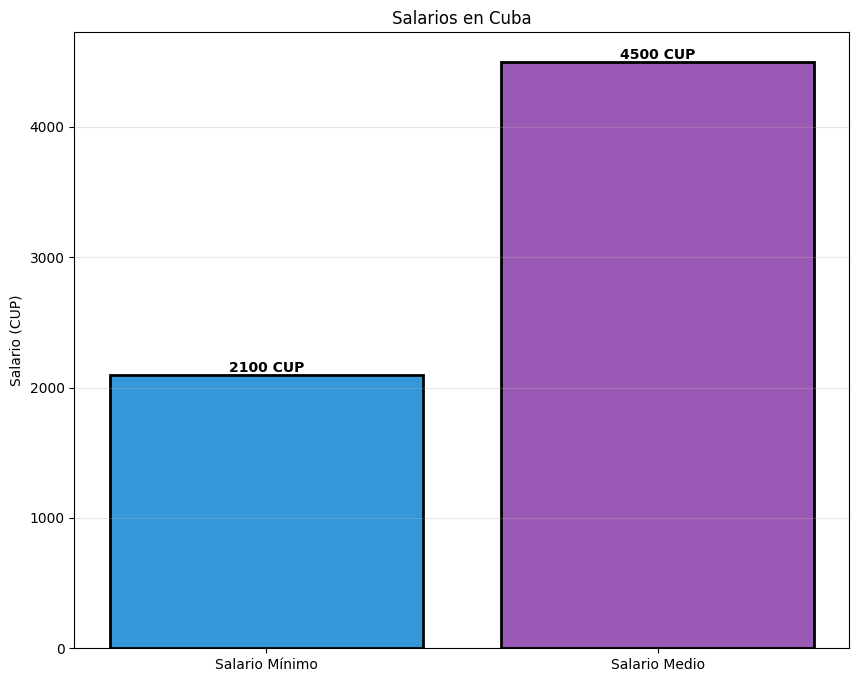

In [22]:
# salarios
fig, ax = plt.subplots(figsize=(10, 8))
salarios = [salario_minimo, salario_medio]
bars = ax.bar(["Salario Mínimo", "Salario Medio"], salarios, color=["#3498db", "#9b59b6"], edgecolor="black", linewidth=2)
ax.set_ylabel("Salario (CUP)")
ax.set_title("Salarios en Cuba")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.0f} CUP", ha="center", va="bottom", fontweight="bold")


## Precio promedio de los productos de la canasta básica

Hasta este punto se han analizado precios individuales y diferencias entre MIPYMES.
Sin embargo, para evaluar el impacto real en la población, es necesario observar el
precio promedio que enfrenta un consumidor al intentar adquirir productos de la
canasta básica en el mercado.

En este análisis se combinan los datos de todas las MIPYMES y del mercado estatal
(El Yerro), calculando el precio promedio de cada producto de la canasta básica
cuando este aparece en el inventario.

Este enfoque permite:
- Reducir el efecto de precios extremos
- Obtener una referencia más realista del mercado
- Sentar las bases para calcular el costo total de la canasta básica


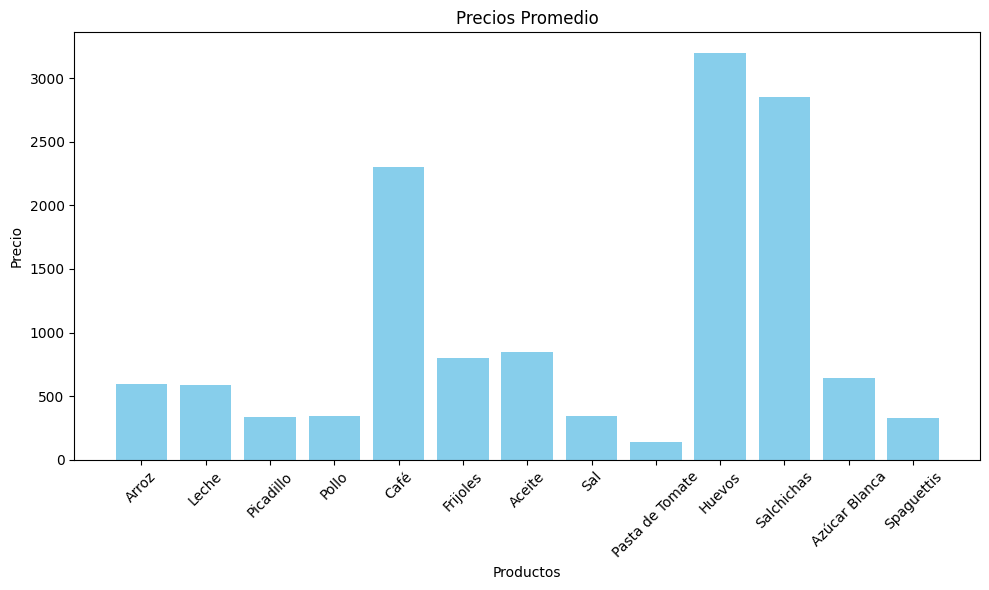

In [32]:
from modules.graphs import union, canasta_b, promedio

precios_productos = {}                 

for tienda in union(mypime, yerro_m):
    for p in tienda["productos"]:
        for cb in canasta_b(canasta_basica):
            if cb["nombre"].lower() in p["nombre"].lower():
                nombre = cb["nombre"]
                precio = p["precio_cup"]
                precios_productos[nombre] = []
                precios_productos[nombre].append(precio)

promedios = {}
for nombre, precios in precios_productos.items():
    if precios:
        promedios[nombre] = promedio(precios)

plt.figure(figsize=(10, 6))
plt.bar(promedios.keys(), promedios.values(), color='skyblue')
plt.title("Precios Promedio")
plt.xlabel("Productos")
plt.xticks(rotation=45)
plt.ylabel("Precio")
plt.tight_layout()
plt.show()                   
    

El gráfico muestra que los precios promedio de los productos básicos se mantienen
elevados incluso al promediar múltiples establecimientos, lo que sugiere que el
problema no es puntual, sino estructural.

Estos valores serán utilizados en la siguiente sección para estimar el costo total
de la canasta básica en el mercado actual.


## Costo de la canasta en relación con el salario

El primer paso es comparar el costo estimado de la canasta básica con el salario mensual.
Esta relación permite evaluar si el ingreso es suficiente para cubrir necesidades básicas.


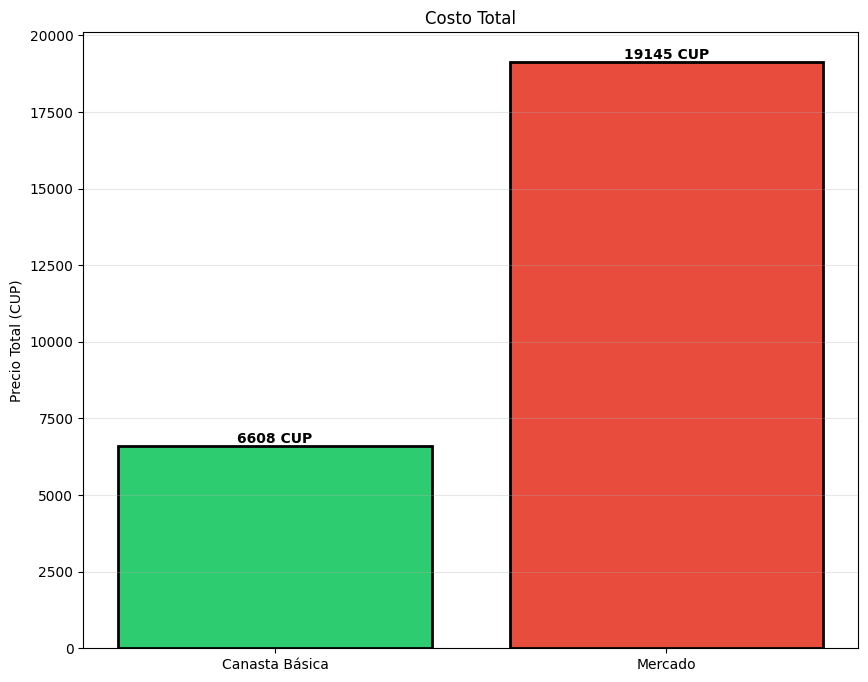

In [23]:
# total canasta básica vs mercado
total_mercado = 0
for i in lista_precio:
    total_mercado += i
    
fig, ax = plt.subplots(figsize=(10, 8))
totales = [total_canasta_basica, total_mercado]
colores = ["#2ecc71", "#e74c3c"]
bars = ax.bar(["Canasta Básica", "Mercado"], totales, color=colores, edgecolor="black", linewidth=2)
ax.set_ylabel("Precio Total (CUP)")
ax.set_title("Costo Total")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.0f} CUP", ha="center", va="bottom", fontweight="bold")



El costo de la canasta básica representa una proporción significativa del ingreso mensual.

Esto indica que el salario promedio no permite sostener una alimentación básica sin comprometer prácticamente todo el ingreso.


## El precio medido en tiempo de trabajo

Expresar los precios en días de trabajo permite traducir el costo económico a una métrica más tangible para el trabajador.




Cada barra es la cantidad TOTAL de horas que una persona con salario mínimo o medio debe trabajar en el mes para poder pagar la canasta básica completa.

No es “cuánto por día”, sino “cuántas horas/días de trabajo necesitas en total para cubrir esa canasta con ese salario”.


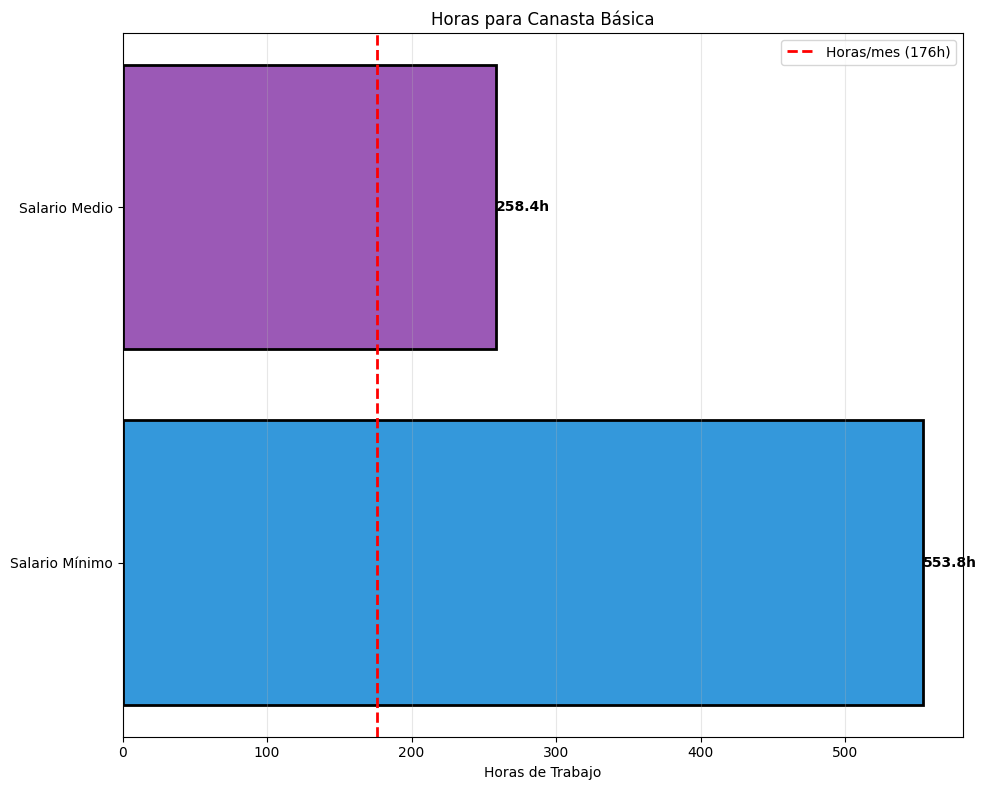

In [24]:
# Horas de trabajo necesarias para cubrir la cansta basica
fig, ax = plt.subplots(figsize=(10, 8))

precio_hora_minimo = salario_minimo / horas_mes
precio_hora_medio = salario_medio / horas_mes

horas_canasta_minimo = total_canasta_basica / precio_hora_minimo
horas_canasta_medio = total_canasta_basica / precio_hora_medio

horas_mercado_minimo = total_mercado / precio_hora_minimo
horas_mercado_medio = total_mercado / precio_hora_medio

dias_canasta_minimo = horas_canasta_minimo / horas_dia
dias_canasta_medio = horas_canasta_medio / horas_dia
dias_mercado_minimo = horas_mercado_minimo / horas_dia
dias_mercado_medio = horas_mercado_medio / horas_dia


horas_cb = [horas_canasta_minimo, horas_canasta_medio]
labels = ["Salario Mínimo", "Salario Medio"]

bars = ax.barh(labels, horas_cb,
               color=["#3498db", "#9b59b6"],
               edgecolor="black",
               linewidth=2)

ax.axvline(x=horas_mes,
           color="red",
           linestyle="--",
           linewidth=2,
           label=f"Horas/mes ({horas_mes}h)")

ax.set_xlabel("Horas de Trabajo")
ax.set_title("Horas para Canasta Básica")
ax.legend()
ax.grid(axis="x", alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax.text(width,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.1f}h",
            ha="left",
            va="center",
            fontweight="bold")

plt.tight_layout()
plt.show()


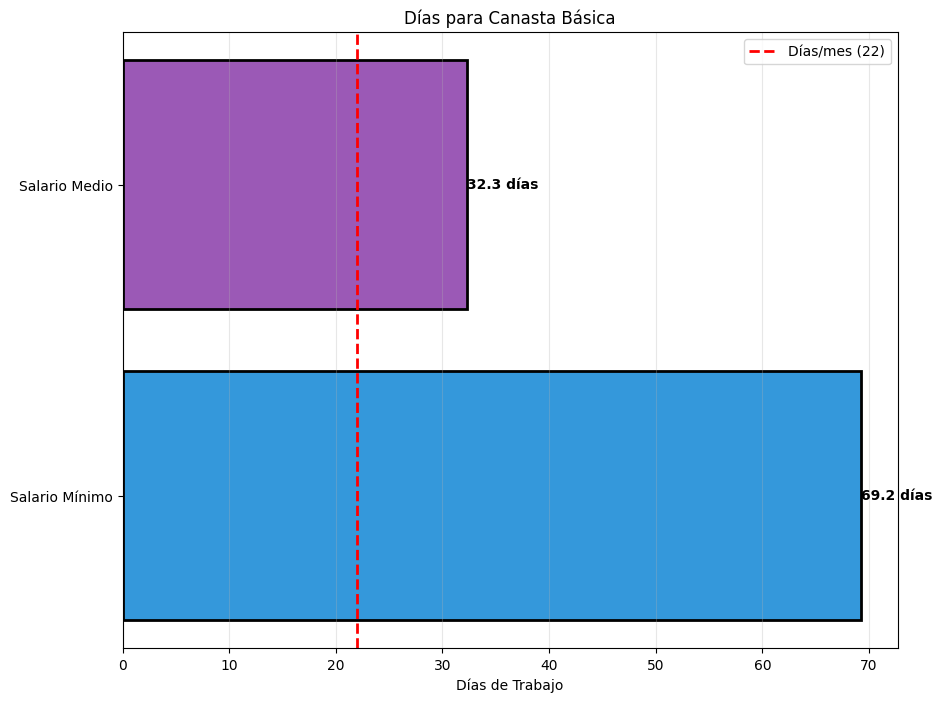

In [25]:
# días de trabajo necesarios (Canasta Básica)
fig, ax = plt.subplots(figsize=(10, 8))
dias_cb = [dias_canasta_minimo, dias_canasta_medio]
bars = ax.barh(["Salario Mínimo", "Salario Medio"], dias_cb, color=["#3498db", "#9b59b6"], edgecolor="black", linewidth=2)
ax.axvline(x=dias_mes, color="red", linestyle="--", linewidth=2, label=f"Días/mes ({dias_mes})")
ax.set_xlabel("Días de Trabajo")
ax.set_title("Días para Canasta Básica")
ax.legend()
ax.grid(axis="x", alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
             f"{width:.1f} días", ha="left", va="center", fontweight="bold")


Medir el precio en días de trabajo revela el esfuerzo necesario para acceder a productos básicos.

En este contexto, el salario no garantiza el acceso estable al consumo, sino que impone decisiones de priorización.


## Metodología del análisis del jabón

En este análisis se utiliza el precio promedio del jabón de lavar y del jabón de baño como una aproximación al costo general de los productos de higiene básica.

Aunque cumplen funciones específicas distintas, ambos productos responden a una misma necesidad esencial y presentan patrones de consumo recurrente en los hogares.


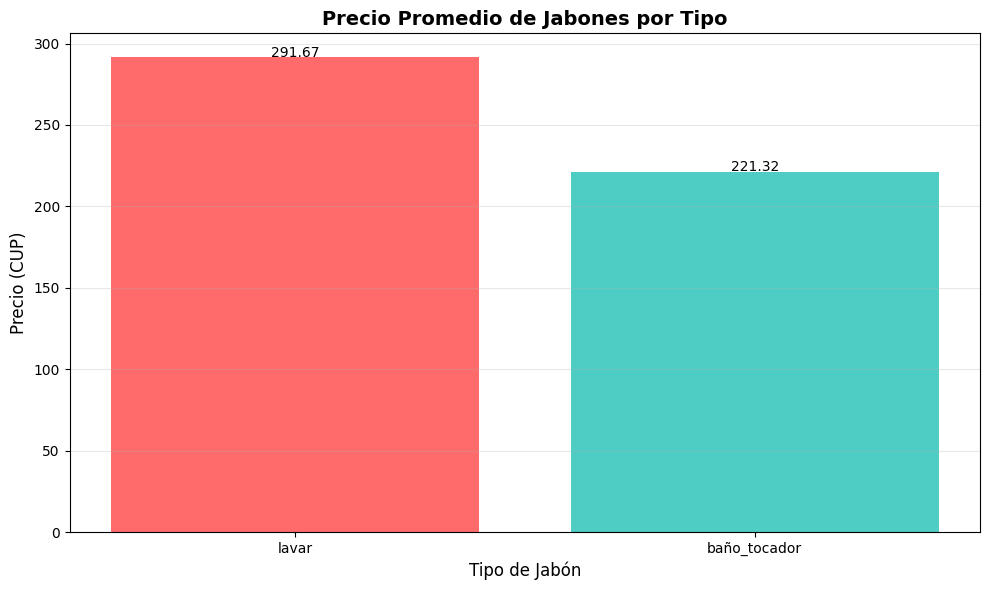

In [27]:
from modules.graphs import productos_yerro, promedio
from collections import Counter

jabones = []

for element in productos_yerro(yerro_m):
    nombre_lower = element["nombre"].lower()
    if "jabon" in nombre_lower:
        
        if "lavar" in nombre_lower:
            tipo = "lavar"
            
        elif "tocador" in nombre_lower or "baño" in nombre_lower:
            tipo = "baño_tocador"
        
        else:
            tipo = "baño_tocador"
        
        precio = element.get("precio_cup") or element.get("precio cup")
        
        jabones.append({
            "nombre": element["nombre"],
            "tipo": tipo,
            "precio": precio
        })

tipos = [j["tipo"] for j in jabones]
contador_tipos = Counter(tipos)

precios_por_tipo = {}

for jabon in jabones:
    tipo = jabon["tipo"]
    precio = jabon["precio"]
    
    if precio is not None:  
        if tipo not in precios_por_tipo:
            precios_por_tipo[tipo] = []
        precios_por_tipo[tipo].append(precio)

if precios_por_tipo:
    promedios = {}
    for tipo, precios in precios_por_tipo.items():
        if precios:
            promedios[tipo] = promedio(precios)
    
    if promedios:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
        
        bars1 = ax1.bar(promedios.keys(), promedios.values(),
                       color=['#FF6B6B', '#4ECDC4', '#FFD166'])
        ax1.set_title('Precio Promedio de Jabones por Tipo', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Precio (CUP)', fontsize=12)
        ax1.set_xlabel('Tipo de Jabón', fontsize=12)
        ax1.grid(True, alpha=0.3, axis='y')
    
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}', ha='center')
    
        plt.tight_layout()
        plt.show()
        

El costo de la canasta básica representa una proporción crítica del ingreso mensual.

Esto indica que el salario promedio no permite cubrir necesidades básicas sin comprometer prácticamente todo el ingreso.


## Síntesis del análisis

A lo largo del análisis se repite un patrón consistente:
precios altos, variabilidad entre mercados y una débil relación con el ingreso.

No se trata de productos aislados ni de mercados específicos, sino de un comportamiento estructural.


## Conclusiones

Los resultados del análisis muestran una desconexión estructural entre el salario promedio y los precios de los productos básicos en las MiPymes.

El mercado no utiliza el salario como referencia para la formación de precios. Como consecuencia, el ingreso mensual del trabajador no garantiza el acceso estable a bienes esenciales, sino que obliga a priorizar, renunciar y postergar consumo.

Cuando productos cotidianos requieren una fracción significativa del salario o varios días de trabajo, el problema deja de ser individual y se vuelve sistémico.

Este análisis no demuestra que los precios sean altos en términos absolutos, sino que son incompatibles con el nivel de ingreso existente. Mientras esa relación no se restablezca, el trabajo perderá su función como mecanismo de acceso al consumo básico.

